<a href="https://colab.research.google.com/github/bosunKwak/BigData/blob/main/model_development.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Overall Process
1. Data prepartion stage
  - Load data
  - Transform (convert it to numeric values)
  - Batching (batch 단위로 묶음)

2. Development stage
  - Design 
  - Training 
    - (weight 값을 찾는 것 == 학습을 시킴)
    - 예측한 결과와 실제 나온 결과의 오차가 가장 minimum 하도록
  - Testing
  - Pytorch의 경우 "torch.nn" module 사용
  - Separate dataset into 3 parts : training, validation, testing
  - Define a loss function and optimizer
  - Backpropagating and Update

3. Model Deployment
  - File에 저장하거나 배포

## 1.Data Preparation Stage


### (1) Data Loading
Example(CIFAR-10)

In [14]:
# torchvision : 이미지 관련된 model이나 model 관련 dataset들이 들어있는 모듈
from torchvision.datasets import CIFAR10

# 파일 다운
train_data = CIFAR10(root="./train/",
                    train=True, 
                    download=True)

Files already downloaded and verified


In [27]:
# data 확인
print(train_data)

# data 길이(개수)
print(len(train_data)) # out: 50000

# 차원
print(train_data.data.shape) 
#(50000, 32, 32, 3)  - 50000개의 set, 32 x 32 인 color image가 3개의 channel로 있음

# target : label (분류하고자하는 정답)
#print(train_data.targets) # list. 너무 많아서 생략. 

# 각 class 이름
print(train_data.classes)

# class가 target에 어떻게 매핑되는지 확인
print(train_data.class_to_idx)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./train/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )
50000
(50000, 32, 32, 3)
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


In [16]:
# 첫번째 train data의 type
print(type(train_data[0]))
# <class 'tuple'>
# tuple : array와 비슷 + 속성을 변경할 수 없는 특징

# 첫 번째 train data의 길이(개수) : 몇 개의 data로 되어있는지 확인
print(len(train_data[0]))

data, label = train_data[0]

# 이미지 타입
print(type(data))
#<class 'PIL.Image.Image'>

# 이미지 정보 
print(data)

<class 'tuple'>
2
<class 'PIL.Image.Image'>
<PIL.Image.Image image mode=RGB size=32x32 at 0x7F7A2E947750>


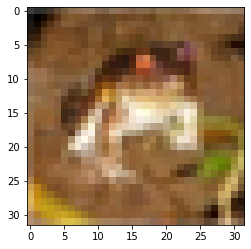

In [17]:
import matplotlib.pyplot as plt

plt.imshow(data)

In [18]:
print(type(label))
# out: <class 'int'>

print(label)
# out: 6 
# 이렇게 숫자로 보면 직관적이지 않으므로, 아래 코드를 통해 train data class의 이름을 가져옴
print(train_data.classes[label])
# out: frog

<class 'int'>
6
frog


In [19]:
test_data = CIFAR10(root="./test/", 
                    train=False, # 이 부분만 다름
                    download=True)

print(test_data)
print(len(test_data))

print(test_data.data.shape) # test 개수만 다른 것을 확인할 수 있음 
# out: (10000, 32, 32, 3)

Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./test/
    Split: Test
10000
(10000, 32, 32, 3)


### (2) Data Transforms

변환을 해주는 이유?
- 학습을 잘 하기 위해서
- model이 사용할 수 있는 형태로 변환해 주기 위해서


In [20]:
from torchvision import transforms

train_transforms = transforms.Compose([
  transforms.RandomCrop(32, padding=4),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  transforms.Normalize(
      (0.4914, 0.4822, 0.4465),
      (0.2023, 0.1994, 0.2010))])

train_data = CIFAR10(root="./train/",
                    train=True, 
                    download=True,
                    transform=train_transforms)

print(train_data)
print(train_data.transforms)

Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./train/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )
StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )


In [21]:
# 첫번째 image만 가져와서 확인
data, label = train_data[0]

print(type(data))
# <class 'torch.Tensor'> : Tensor로 바뀐것을 확인 할 수 있음

print(data.size())
# torch.Size([3, 32, 32]) : 채널 정보가 앞으로 감 
print(data)

<class 'torch.Tensor'>
torch.Size([3, 32, 32])
tensor([[[-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
         [-2.4291, -2.4291, -2.4291,  ...,  0.8276,  0.6531,  0.6338],
         [-2.4291, -2.4291, -2.4291,  ...,  0.1297,  0.1491,  0.1491],
         ...,
         [-2.4291, -2.4291, -2.4291,  ...,  0.0328, -0.2192,  1.1765],
         [-2.4291, -2.4291, -2.4291,  ..., -0.6844, -1.4598,  0.2267],
         [-2.4291, -2.4291, -2.4291,  ..., -1.3047, -1.7700,  0.1104]],

        [[-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
         [-2.4183, -2.4183, -2.4183,  ...,  0.2564,  0.1188,  0.1384],
         [-2.4183, -2.4183, -2.4183,  ..., -0.6286, -0.5696, -0.5302],
         ...,
         [-2.4183, -2.4183, -2.4183,  ..., -0.4319, -0.7072,  0.6301],
         [-2.4183, -2.4183, -2.4183,  ..., -1.0612, -1.9463, -0.3532],
         [-2.4183, -2.4183, -2.4183,  ..., -1.8086, -2.3199, -0.5696]],

        [[-2.2214, -2.2214, -2.2214,  ..., -2.2214, -2.2214, -2.2214]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


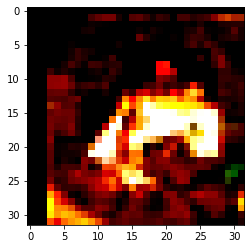

In [22]:
# permute : 차원의 순서를 변경해줌 ("3,32,32"를 "32, 32, 3"으로 변환)
plt.imshow(data.permute(1, 2, 0))

In [26]:
# test set을 불러올때도 변환을 해 줌
# 성능 향상을 위한 이미지 전처리가 필요 없음
test_transforms = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(
      (0.4914, 0.4822, 0.4465),
      (0.2023, 0.1994, 0.2010))])

test_data = CIFAR10(
      root="./test/", 
      train=False, 
      transform=test_transforms)

print(test_data)

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./test/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )


#### 데이터를 직접 불러오는 방식
> - Dataset : 소스에서 data를 불러오는 것
> - DataLoader : Sampler를 통해 불러온 data의 일부만 가져옴
> - Sampler classes : 불러온 dataset에서 sampling해서 쓰거나, 특정 크기로 batch(잘라서 사용)